Name : Pranavah Varun

Reg No. : 3122237001039

Email Spam or Ham Classification using Na¨ıve Bayes, KNN, and
SVM

Configuration Section (User-Editable Block)

In [1]:
DATA_PATH = "/content/drive/MyDrive/spambase_csv.csv"
TARGET_COLUMN = 'class'

# Features will be auto-detected as all except target
TEST_SIZE = 0.2
RANDOM_STATE = 42
KFOLD_SPLITS = 5

1) Load and Preprocess Dataset

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# Mount Drive & Load CSV
drive.mount('/content/drive')

# Load data
df = pd.read_csv(DATA_PATH)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# Drop rows with missing values
df = df.dropna()

# Ensure target is categorical
df[TARGET_COLUMN] = df[TARGET_COLUMN].astype('category')

# Feature/Label split
X_raw = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Train-test split for both raw and scaled data
X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y)

X_scaled_train, X_scaled_test, _, _ = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'w

2) EDA: Class Distribution + Feature Distributions

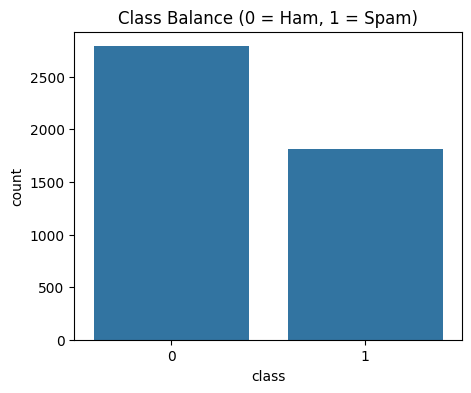

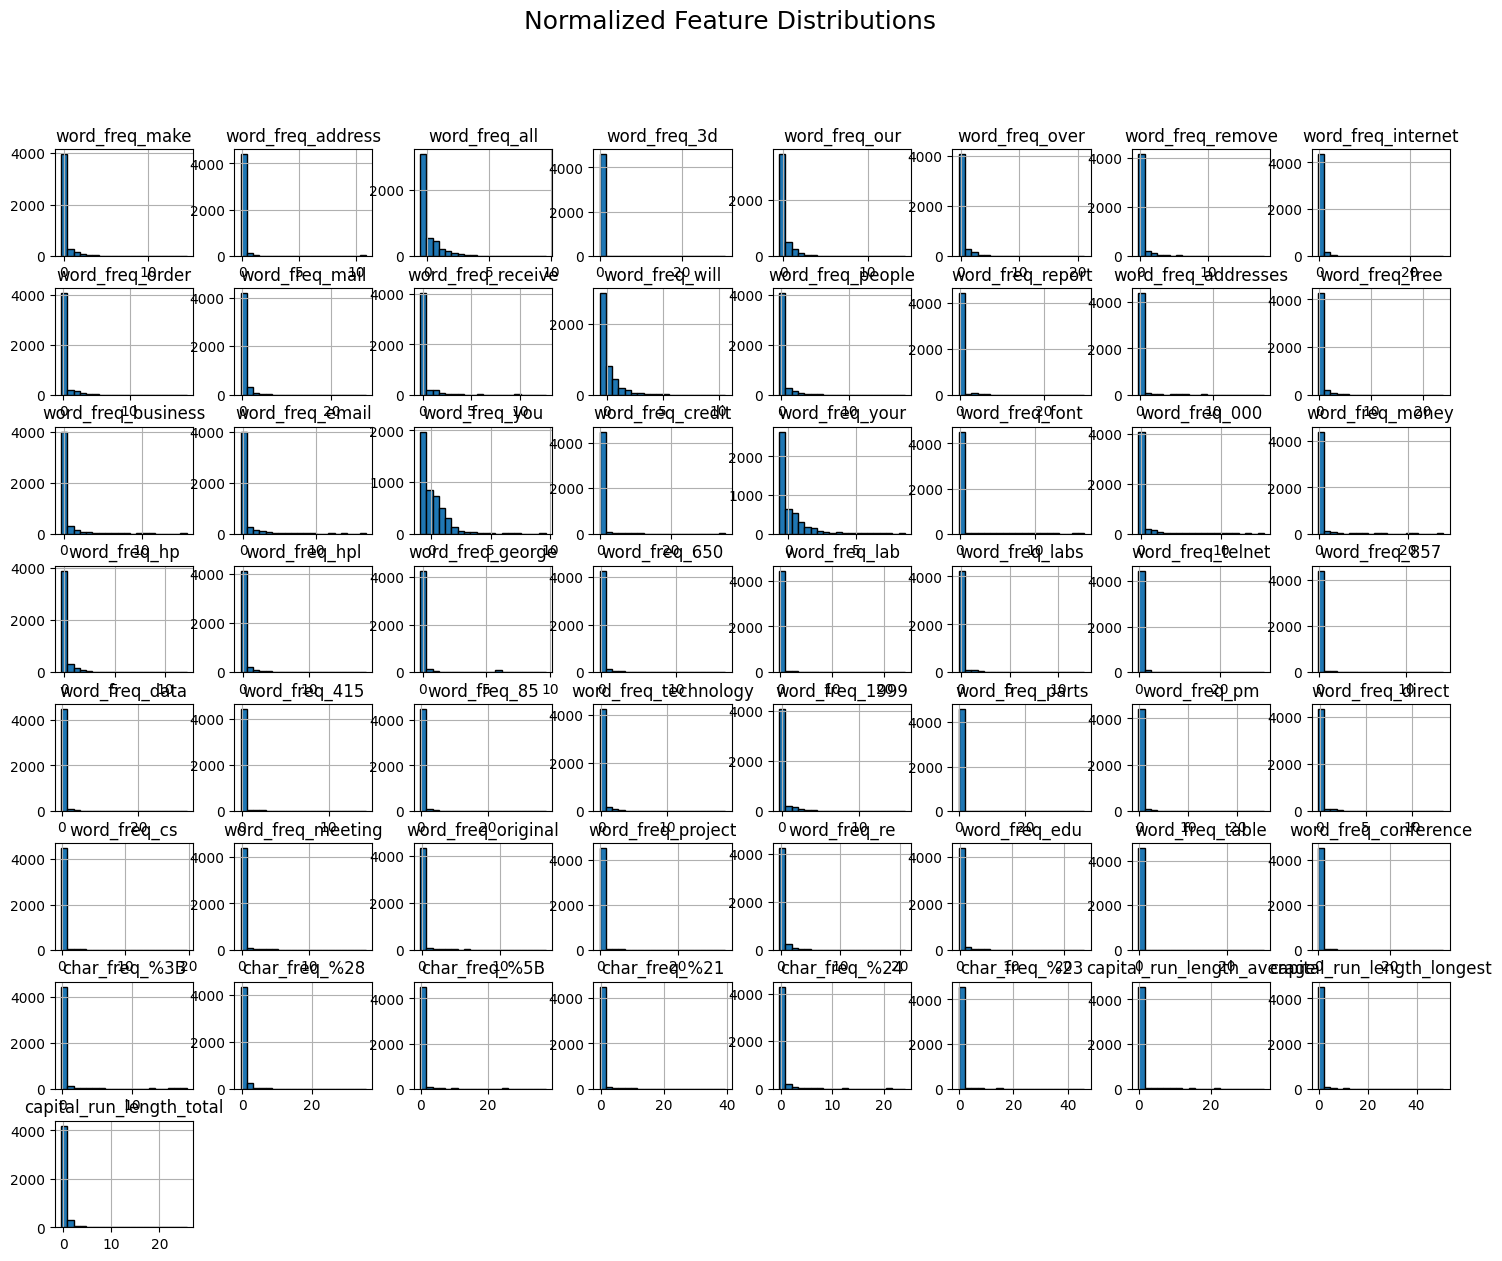

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.countplot(x=y)
plt.title("Class Balance (0 = Ham, 1 = Spam)")
plt.show()

# Optional: Histogram of features
X_df = pd.DataFrame(X_scaled, columns=X_raw.columns)
X_df.hist(figsize=(18, 14), bins=20, edgecolor='black')
plt.suptitle("Normalized Feature Distributions", fontsize=18)
plt.show()

3) Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (3680, 57), Test: (921, 57)


4) Train Models (NB, KNN, SVM)

In [18]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    # Naïve Bayes
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),

    # KNN with different k values
    "KNN_k=3": KNeighborsClassifier(n_neighbors=3, algorithm='auto'),
    "KNN_k=5_KDTree": KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree'),
    "KNN_k=7_BallTree": KNeighborsClassifier(n_neighbors=7, algorithm='ball_tree'),

    # SVM with different kernels
    "SVM_Linear": SVC(kernel='linear', C=1.0, probability=True),
    "SVM_Polynomial": SVC(kernel='poly', degree=3, C=1.0, gamma='scale', probability=True),
    "SVM_RBF": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True),
    "SVM_Sigmoid": SVC(kernel='sigmoid', C=1.0, gamma='scale', probability=True),
}

5) Evaluation Function (Accuracy, F1, Confusion Matrix, ROC)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def evaluate_model(name, model, X_test, y_test):
    print(f"\n🔍 Evaluating: {name}")
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    try:
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test.cat.codes, y_scores)
        auc_score = roc_auc_score(y_test.cat.codes, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"ROC Curve skipped for {name}: {e}")

6) Train and Evaluate All Models

6.1) Naive Bayes


🔍 Evaluating: GaussianNB
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       558
           1       0.72      0.95      0.82       363

    accuracy                           0.83       921
   macro avg       0.84      0.85      0.83       921
weighted avg       0.87      0.83      0.84       921



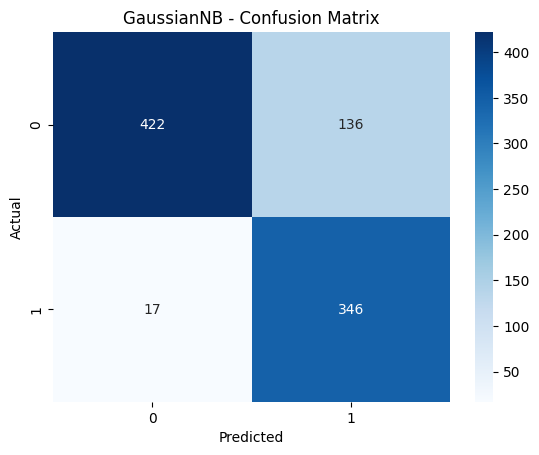

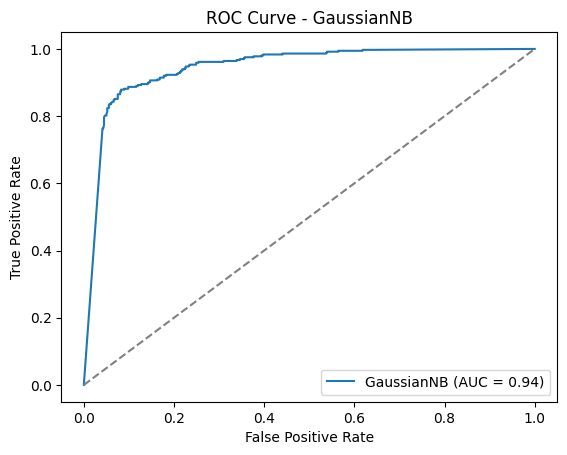


🔍 Evaluating: MultinomialNB
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       558
           1       0.72      0.71      0.71       363

    accuracy                           0.78       921
   macro avg       0.77      0.76      0.77       921
weighted avg       0.78      0.78      0.78       921



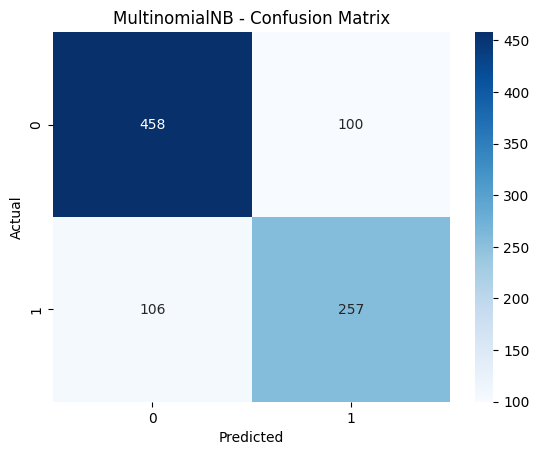

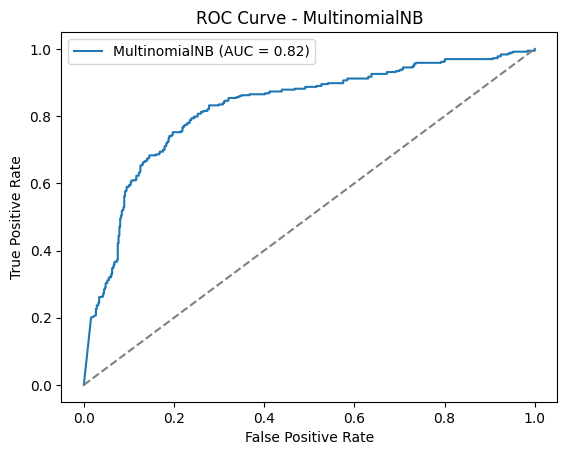


🔍 Evaluating: BernoulliNB
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       558
           1       0.87      0.80      0.84       363

    accuracy                           0.88       921
   macro avg       0.88      0.86      0.87       921
weighted avg       0.88      0.88      0.88       921



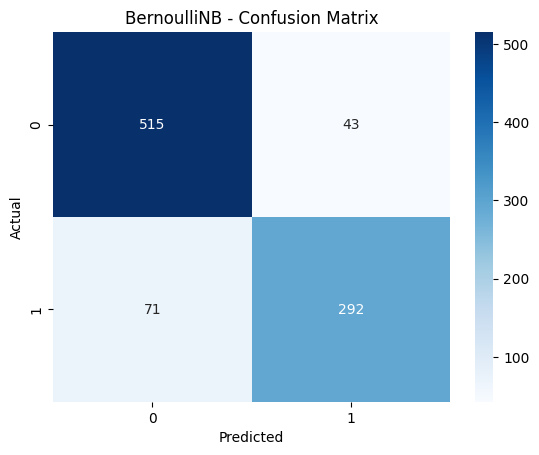

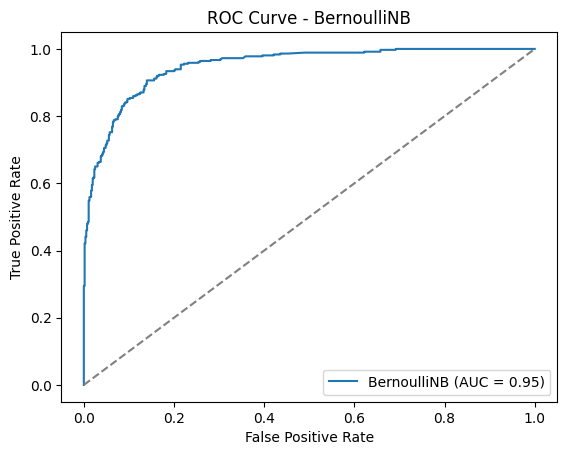

In [20]:
nb_models = {k: v for k, v in models.items() if "NB" in k}

for name, model in nb_models.items():
    model.fit(X_raw_train, y_train)
    evaluate_model(name, model, X_raw_test, y_test)

6.2) Evaluate KNN Models


🔍 Evaluating: KNN_k=3
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       558
           1       0.88      0.87      0.87       363

    accuracy                           0.90       921
   macro avg       0.90      0.89      0.90       921
weighted avg       0.90      0.90      0.90       921



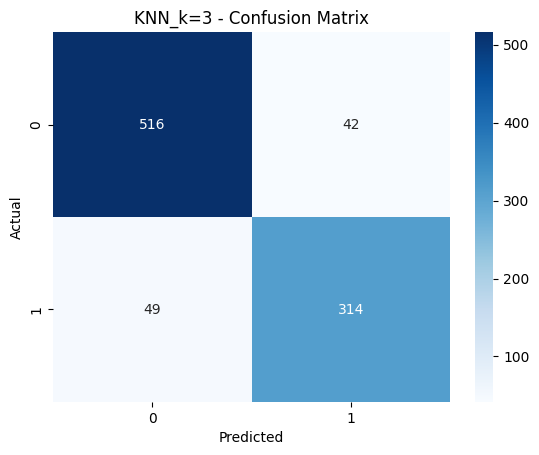

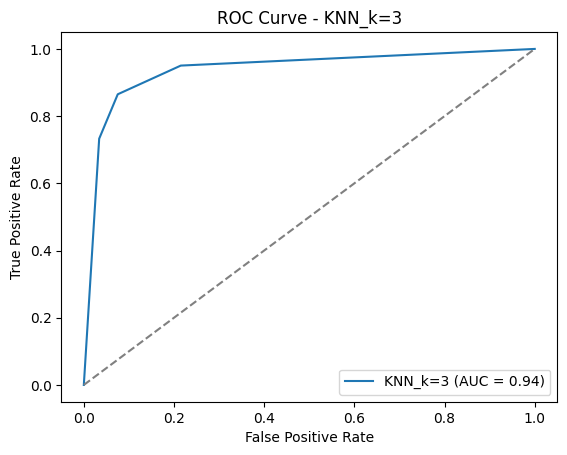


🔍 Evaluating: KNN_k=5_KDTree
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       558
           1       0.89      0.87      0.88       363

    accuracy                           0.91       921
   macro avg       0.90      0.90      0.90       921
weighted avg       0.91      0.91      0.91       921



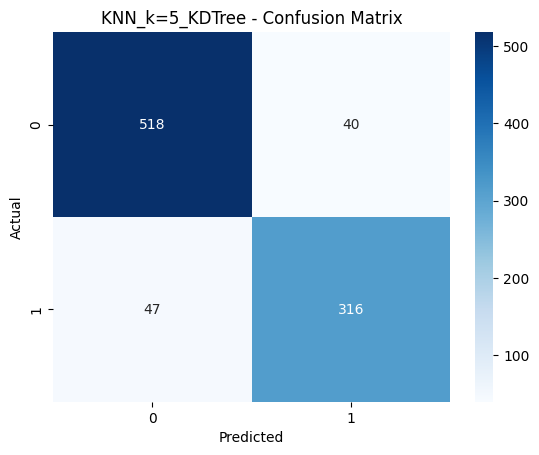

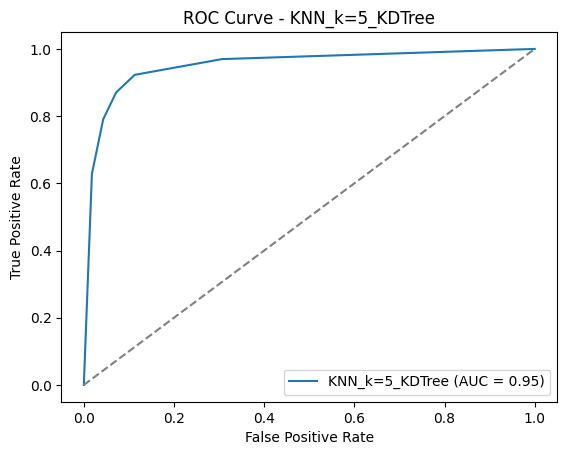


🔍 Evaluating: KNN_k=7_BallTree
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       558
           1       0.89      0.87      0.88       363

    accuracy                           0.91       921
   macro avg       0.91      0.90      0.90       921
weighted avg       0.91      0.91      0.91       921



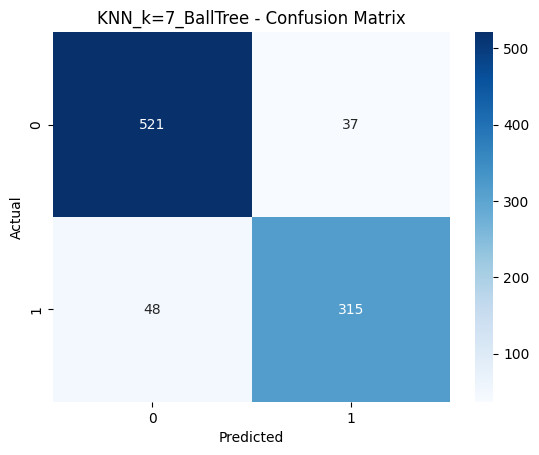

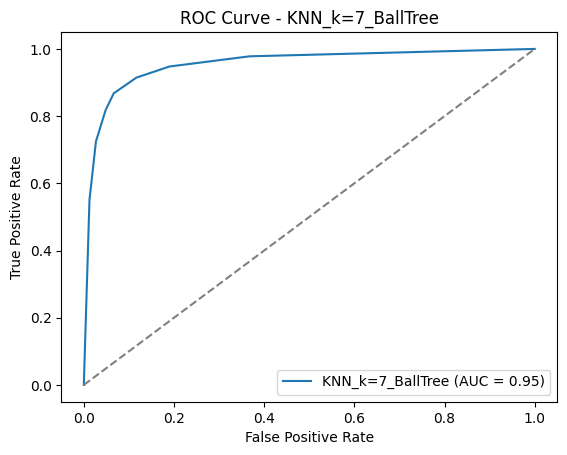

In [21]:
knn_models = {k: v for k, v in models.items() if "KNN" in k}

for name, model in knn_models.items():
    model.fit(X_scaled_train, y_train)
    evaluate_model(name, model, X_scaled_test, y_test)

In [22]:
import time
from sklearn.neighbors import KNeighborsClassifier

# Example for KDTree (k=5)
start_time = time.time()

knn_kd = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
knn_kd.fit(X_scaled, y)

end_time = time.time()
kd_training_time = end_time - start_time
print(f"KDTree Training Time: {kd_training_time:.4f} seconds")

# Example for BallTree (k=7)
start_time = time.time()

knn_ball = KNeighborsClassifier(n_neighbors=7, algorithm='ball_tree')
knn_ball.fit(X_scaled, y)

end_time = time.time()
ball_training_time = end_time - start_time
print(f"BallTree Training Time: {ball_training_time:.4f} seconds")


KDTree Training Time: 0.0840 seconds
BallTree Training Time: 0.0818 seconds


6.3) Evaluate SVM Models


🔍 Evaluating: SVM_Linear
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       558
           1       0.92      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.93       921
weighted avg       0.93      0.93      0.93       921



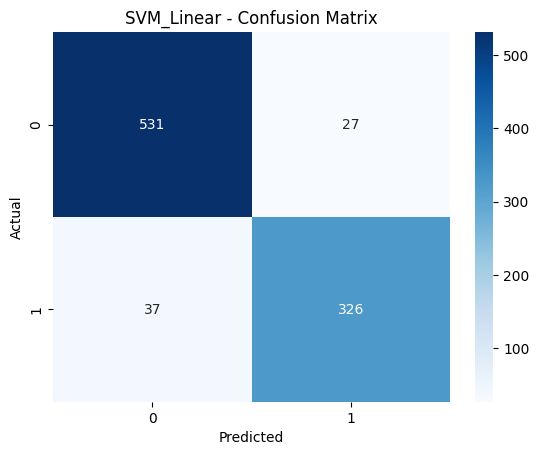

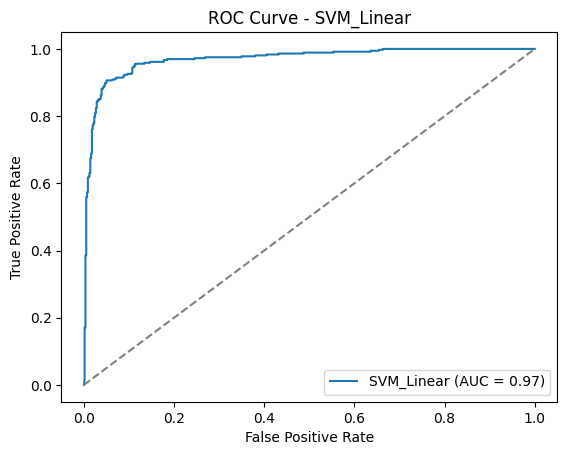


🔍 Evaluating: SVM_Polynomial
              precision    recall  f1-score   support

           0       0.74      0.99      0.84       558
           1       0.96      0.46      0.62       363

    accuracy                           0.78       921
   macro avg       0.85      0.72      0.73       921
weighted avg       0.83      0.78      0.76       921



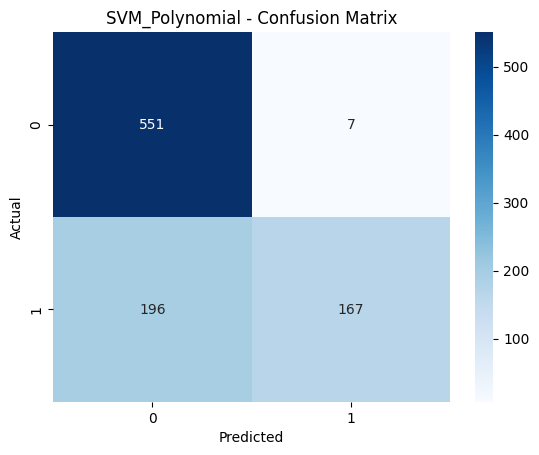

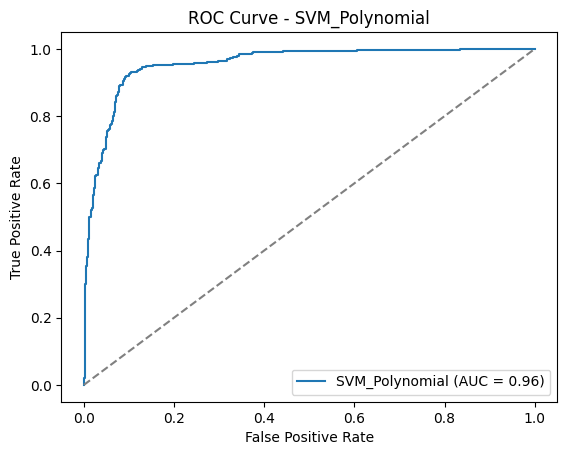


🔍 Evaluating: SVM_RBF
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       558
           1       0.93      0.88      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



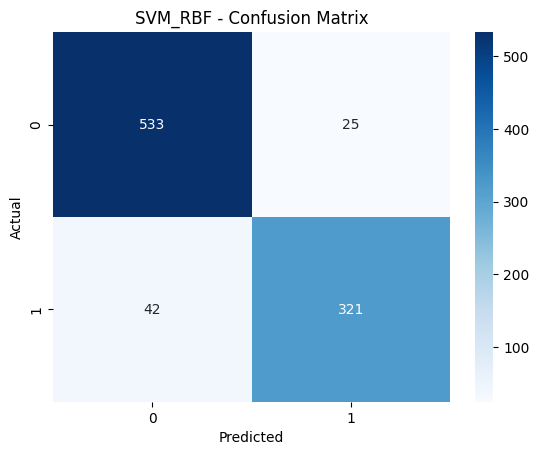

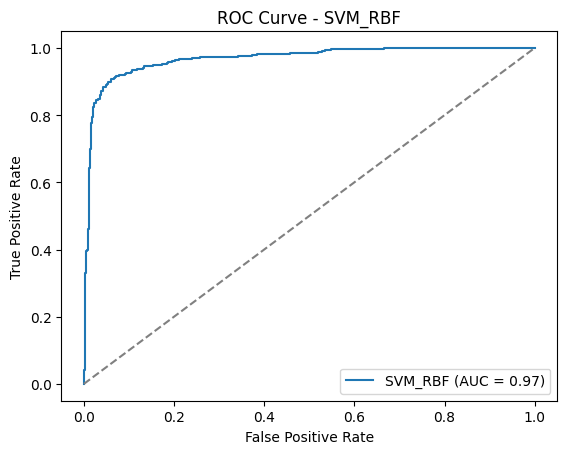


🔍 Evaluating: SVM_Sigmoid
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       558
           1       0.85      0.85      0.85       363

    accuracy                           0.88       921
   macro avg       0.88      0.88      0.88       921
weighted avg       0.88      0.88      0.88       921



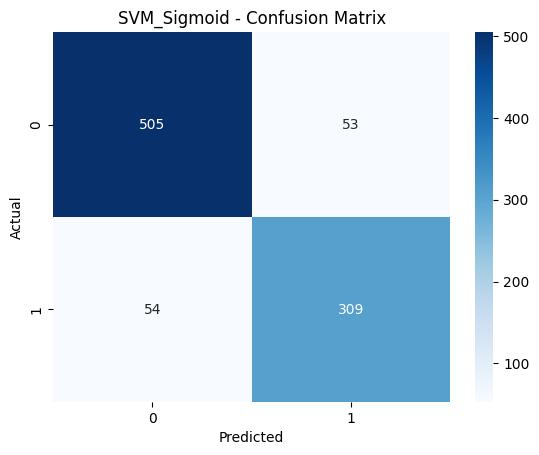

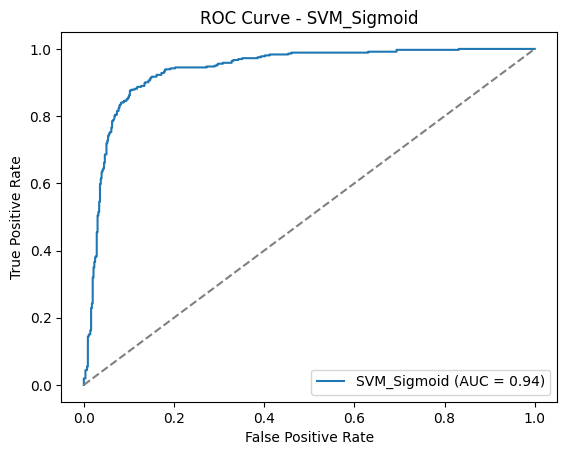

In [ ]:
svm_models = {k: v for k, v in models.items() if "SVM" in k}

for name, model in svm_models.items():
    model.fit(X_scaled_train, y_train)
    evaluate_model(name, model, X_scaled_test, y_test)

In [23]:
import time
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # assuming X_train is already defined

# Kernels to evaluate
svm_kernels = {
    "Linear": SVC(kernel='linear', C=1.0),
    "Polynomial": SVC(kernel='poly', C=1.0, degree=3, gamma='scale'),
    "RBF": SVC(kernel='rbf', C=1.0, gamma='scale'),
    "Sigmoid": SVC(kernel='sigmoid', C=1.0, gamma='scale'),
}

# Evaluate each kernel
for name, model in svm_kernels.items():
    print(f"\nEvaluating: SVM_{name}")

    start_time = time.time()
    model.fit(X_scaled, y_train)  # assuming y_train is defined
    end_time = time.time()

    train_time = end_time - start_time

    y_pred = model.predict(X_test)  # assuming X_test is already scaled or scale it too

    print(classification_report(y_test, y_pred))  # assuming y_test is defined
    print(f"Training Time: {train_time:.4f} seconds")



Evaluating: SVM_Linear
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       558
           1       0.92      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.93       921
weighted avg       0.93      0.93      0.93       921

Training Time: 4.6957 seconds

Evaluating: SVM_Polynomial
              precision    recall  f1-score   support

           0       0.75      0.99      0.85       558
           1       0.96      0.48      0.64       363

    accuracy                           0.79       921
   macro avg       0.85      0.73      0.75       921
weighted avg       0.83      0.79      0.77       921

Training Time: 1.3001 seconds

Evaluating: SVM_RBF
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       558
           1       0.93      0.89      0.91       363

    accuracy                           0.93      

7) K-Fold Cross Validation (K=5)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

print("\n5-Fold Cross Validation Results:")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    if "MultinomialNB" in name:
        scores = cross_val_score(model, X_raw, y, cv=kfold, scoring='accuracy')
    else:
        scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='accuracy')

    print(f"{name:20} → Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


5-Fold Cross Validation Results:
GaussianNB           → Accuracy: 0.8155 ± 0.0091
MultinomialNB        → Accuracy: 0.7916 ± 0.0130
BernoulliNB          → Accuracy: 0.9022 ± 0.0075
KNN_k=3              → Accuracy: 0.9070 ± 0.0032
KNN_k=5_KDTree       → Accuracy: 0.9087 ± 0.0088
KNN_k=7_BallTree     → Accuracy: 0.9059 ± 0.0073
SVM_Linear           → Accuracy: 0.9261 ± 0.0056
SVM_Polynomial       → Accuracy: 0.7783 ± 0.0093
SVM_RBF              → Accuracy: 0.9322 ± 0.0062
SVM_Sigmoid          → Accuracy: 0.8844 ± 0.0066


In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/spambase_csv.csv')

# Separate features and target
X = df.drop(columns=['class'])
y = df['class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [27]:
print(X_scaled.shape)
print(y.shape)


(4601, 57)
(4601,)


In [28]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

nb_scores = cross_val_score(nb_model, X_scaled, y, cv=cv, scoring='accuracy')
knn_scores = cross_val_score(knn_model, X_scaled, y, cv=cv, scoring='accuracy')
svm_scores = cross_val_score(svm_model, X_scaled, y, cv=cv, scoring='accuracy')


In [29]:
print("K-Fold Cross-Validation Results (K = 5):")
print("Naïve Bayes Accuracy per Fold:", nb_scores)
print("KNN Accuracy per Fold:", knn_scores)
print("SVM Accuracy per Fold:", svm_scores)

print("\nAverage Scores:")
print("Naïve Bayes Average Accuracy:", nb_scores.mean())
print("KNN Average Accuracy:", knn_scores.mean())
print("SVM Average Accuracy:", svm_scores.mean())


K-Fold Cross-Validation Results (K = 5):
Naïve Bayes Accuracy per Fold: [0.82193268 0.80326087 0.79456522 0.82282609 0.83369565]
KNN Accuracy per Fold: [0.89576547 0.90434783 0.92934783 0.90326087 0.90978261]
SVM Accuracy per Fold: [0.92508143 0.92826087 0.91630435 0.93695652 0.93043478]

Average Scores:
Naïve Bayes Average Accuracy: 0.8152561015908983
KNN Average Accuracy: 0.9085009205494972
SVM Average Accuracy: 0.9274075909927773
